# Entropies & Dimensions


Topics:
* Entropies from **DynamicalSystems.jl**
* Generalized Dimension
* Automated dimension estimation!
* Other related concepts
* Docstrings

---

# Generalized Entropy

* In the study of dynamical systems there are many quantities that identify as "entropy".
* These quantities are not the more commonly known [thermodynamic ones](https://en.wikipedia.org/wiki/Entropy), used in Statistical Physics. 
* Rather, they are more like the entropies of [information theory](https://en.wikipedia.org/wiki/Entropy_(information_theory), which represents information contained within a dataset. 
* In general, the more "uncertain" or "random" the dataset is, the larger its entropy will be. On the other hand, the lower the entropy the more "predictable" the dataset becomes.


Let $p$ be an array of probabilities (such that it sums to 1). Then the generalized entropy is defined as 

$$
R_\alpha(p) = \frac{1}{1-\alpha}\log\left(\sum_i p[i]^\alpha\right)
$$

and is also called [Rényi entropy](https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy). Other entropies, like e.g. the [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) are generalized by it.

This entropy can be computed for a specific dataset. But how does one get $p$?
1. $p$ represents the probability that a point of a dataset falls into a specific "bin". 
2. It is nothing more than the (normalized) histogram of the dataset!

In [44]:
using DynamicalSystems

In [45]:
# Generate a dataset:
N = 100000
randomdata = Dataset(rand(N,3))

3-dimensional Dataset{Float64} with 100000 points:
 0.51159   0.734232   0.625849 
 0.995462  0.0501513  0.0972039
 0.798142  0.503594   0.897876 
 0.995804  0.46882    0.346699 
 0.959351  0.809478   0.725458 
 0.226904  0.794051   0.480696 
 0.788028  0.785284   0.058842 
 0.789814  0.47515    0.664752 
 0.926029  0.34376    0.611014 
 0.332269  0.963587   0.867504 
 0.235013  0.641796   0.345215 
 0.855076  0.053154   0.0331993
 0.331063  0.644122   0.37915  
 ⋮                             
 0.129069  0.159609   0.62602  
 0.137689  0.610574   0.234731 
 0.618584  0.793396   0.030968 
 0.906746  0.436305   0.44431  
 0.556949  0.181238   0.245684 
 0.419648  0.943248   0.398656 
 0.344739  0.627331   0.306907 
 0.82992   0.648138   0.51179  
 0.64436   0.672047   0.994362 
 0.953245  0.475283   0.623774 
 0.826756  0.0791202  0.601749 
 0.176872  0.965667   0.211595 


---

```julia
genentropy(α, ε, dataset::AbstractDataset; base = e)
```
* This function calculates the generalized entropy of order `α`.
* It first calculates the probability array $p$.
* The "histogram" is performed by partitioning the `dataset` into boxes of size `ε`.


In [46]:
genentropy(1, 0.1, randomdata)

6.902756046089437

In [47]:
genentropy(1, 0.01, randomdata)

11.444070141622941

In [48]:
genentropy(1, 0.001, randomdata)

11.512870013172

In [49]:
genentropy(1, 0.0001, randomdata)

11.51292546494644

* Value has already saturated. No use in partitioning the dataset in smaller boxes.

---



In [50]:
# entropy of a coin toss:
y = Float64.(rand(Bool, 1000000)) # just some coin tosses
sh = genentropy(1, 0.1, y) # this is the shannon entropy

0.6931471597519452

The above number should be log(2) [by definition](https://en.wikipedia.org/wiki/Shannon_(unit)

In [51]:
isapprox(sh, log(2), rtol = 1e-4)

true

In [97]:
# entropy is best used with `trajectory`
towel = Systems.towel()
tr = trajectory(towel, N-1);
summary(tr)

"DynamicalSystemsBase.Dataset{3,Float64}"

In [53]:
genentropy(1, 0.01, tr) # The result is with log base-e !

9.47195269047054

Let's also compare the entropy of the above dataset (which is a trajectory of the towel map) with a random dataset:

In [54]:
genentropy(1, 0.01, randomdata)

11.444070141622941

* As expected, the entropy of the random dataset is higher.

---

How much time does the computation take?

In [55]:
using BenchmarkTools
@btime genentropy(1, 0.01, $tr);

  18.475 ms (42 allocations: 3.05 MiB)


## Specialized histogram
1. Partitioning the dataset (i.e. doing a "histogram") is in general a costly operation that depends exponentially on the number of dimensions.
2. In this specific application however, we can reduce tremendously the memory allocation and spent time!
3. For example, the bins without any elements are useless, why compute them?
4. Internally `genentropy` uses the `non0hist` function to partition the dataset.
5. It uses a dictionary to collect the information of bins with elements, while it completely disregards empty bins.
6. It also stores no information about the edges of the binning, since they are also useless.

In [56]:
# Get the array of probabilities $p$ for size ε:
ε = 0.01
p = non0hist(ε, tr)

19407-element Array{Float64,1}:
 1.0e-5 
 4.0e-5 
 2.0e-5 
 5.0e-5 
 1.0e-5 
 1.0e-5 
 7.0e-5 
 0.00015
 4.0e-5 
 5.0e-5 
 1.0e-5 
 7.0e-5 
 5.0e-5 
 ⋮      
 3.0e-5 
 5.0e-5 
 8.0e-5 
 1.0e-5 
 0.00013
 2.0e-5 
 2.0e-5 
 2.0e-5 
 0.00011
 1.0e-5 
 4.0e-5 
 2.0e-5 

In [57]:
sum(p)

0.9999999999999992

In [58]:
@btime non0hist($ε, $tr)

  18.154 ms (37 allocations: 3.05 MiB)


19407-element Array{Float64,1}:
 1.0e-5 
 4.0e-5 
 2.0e-5 
 5.0e-5 
 1.0e-5 
 1.0e-5 
 7.0e-5 
 0.00015
 4.0e-5 
 5.0e-5 
 1.0e-5 
 7.0e-5 
 5.0e-5 
 ⋮      
 3.0e-5 
 5.0e-5 
 8.0e-5 
 1.0e-5 
 0.00013
 2.0e-5 
 2.0e-5 
 2.0e-5 
 0.00011
 1.0e-5 
 4.0e-5 
 2.0e-5 

In [59]:
# Create 9-dimensional data and compare again:
six = Dataset(rand(N, 9))
@btime non0hist($ε, $six);

  54.387 ms (44 allocations: 28.53 MiB)


* We went from dimension 3 to dimension 9
* The speed was roughly only tripled
* In a "typical" histogram computation, in 9 dimensions you already run out of memory.

## Permutation entropy

The other function of **DynamicalSystems.jl** which calculates some entropy, the permutation entropy, is called `permentropy`. This won't be discussed here but is of course available in the [documentation](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/entropies/#permutation-entropy) along with an example application.

# Attractor Dimension
1. There are numerous methods that one can use to calculate a so-called "dimension" of a
dataset, like for example the [Fractal dimension](https://en.wikipedia.org/wiki/Fractal_dimension).

2. Most of the time these dimensions indicate some kind of scaling behavior. 

3. For example, the scaling of `genentropy` with decreasing `ε` gives the so-called "generalized dimension".


$ E \approx -D\log(\varepsilon)$ with $E$ the entropy and $D$ the "dimension".


In [60]:
# I want to know dimension of attractor of the Towel Map!
towel = Systems.towel()
tr = trajectory(towel, 1000000);
# more points = more precision = more computations = more time!

In [61]:
# I want to compute `genentropy` for different ε.
# Which ε to use?...
# Let's do a "random" logspace based guess...
ες = logspace(-4, 1, 12)

12-element Array{Float64,1}:
  0.0001     
  0.000284804
  0.000811131
  0.00231013 
  0.00657933 
  0.0187382  
  0.053367   
  0.151991   
  0.432876   
  1.23285    
  3.51119    
 10.0        

In [62]:
Es = zeros(ες)
for (i, ε) ∈ enumerate(ες)
    Es[i] = genentropy(1, ε, tr)
end
Es

12-element Array{Float64,1}:
 13.8116 
 13.781  
 13.5601 
 12.5477 
 10.4825 
  8.23824
  6.05165
  3.7852 
  1.6531 
 -0.0    
 -0.0    
 -0.0    

Alright. Remember that it should be that $E \approx -D\log(\varepsilon)$
 with $E$ the entropy and $D$ the "dimension". 

Let's plot and see:

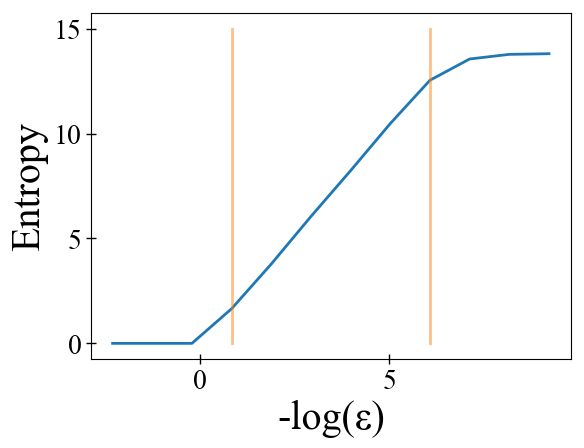

In [63]:
using PyPlot; figure(figsize = (6,4))
x = -log.(ες)
plot(x, Es); xlabel("-log(ε)"); ylabel("Entropy");
plot([x[4], x[4]], [0, 15], color = "C1", alpha = 0.5)
plot([x[end-3], x[end-3]], [0, 15], color = "C1", alpha = 0.5);

What typically happens is that there is some region where this scaling behavior holds, but then it stops holding due to the finite amount of data points.

In [64]:
# Choose the curve points that do fall in linear scope
x, y = -log.(ες)[4:end-2], Es[4:end-2]
# Find the slope of the curve there.
offset, slope = linreg(x, y)
D = slope

2.03902652552714

This is actually a correct result, the information dimension of the attractor of the towel map is around 2.

---

* Are the values of `ες` we used good? 
* For a general dataset, how to determine them?

the function `estimate_boxsizes(dataset; kwargs...)` can help with that!

In [66]:
ες = estimate_boxsizes(tr)

12-element Array{Float64,1}:
 0.0001     
 0.000187382
 0.000351119
 0.000657933
 0.00123285 
 0.00231013 
 0.00432876 
 0.00811131 
 0.0151991  
 0.0284804  
 0.053367   
 0.1        

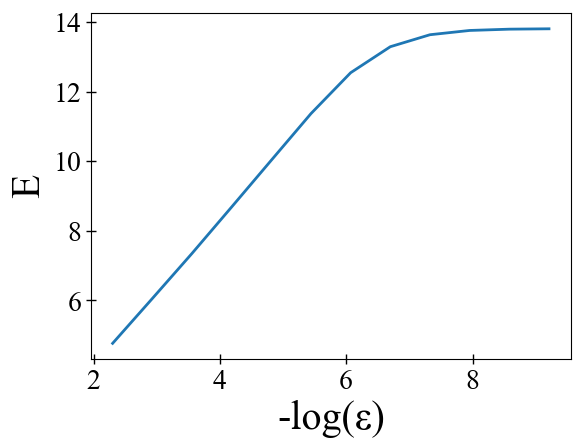

In [67]:
# plot this scaling thingy again
Es = zeros(ες)
for (i, ε) ∈ enumerate(ες)
    Es[i] = genentropy(1, ε, tr)
end
figure(figsize = (6,4))
plot(-log.(ες), Es); xlabel("-log(ε)"); ylabel("E");

---
# Automated Dimension Estimation

Given some arbitrary plot like the one above, is there any algorithm to deduce a scaling region???

* **WE GOT YOU COVERED!**

The function `linear_regions(x, y; kwargs...)` decomposes the function `y(x)` into regions where linear scaling holds!

It returns the indices of `x` that correspond to linear regions and the approximated tangents at each region!

In [68]:
x = -log.(ες)
lrs, slopes = linear_regions(x, Es)

([1, 2, 3, 4, 5, 6, 12], [0.0169754, 0.059061, 0.195576, 0.549296, 1.19167, 1.87214])

In [69]:
for i in 1:length(slopes)
    println("linear region $(i) starts from index $(lrs[i]) and ends at index $(lrs[i+1])")
    println("with corresponding slope $(slopes[i])")
    println()
end

linear region 1 starts from index 1 and ends at index 2
with corresponding slope 0.01697540475919078

linear region 2 starts from index 2 and ends at index 3
with corresponding slope 0.059060992416266674

linear region 3 starts from index 3 and ends at index 4
with corresponding slope 0.19557558745055342

linear region 4 starts from index 4 and ends at index 5
with corresponding slope 0.5492959963318305

linear region 5 starts from index 5 and ends at index 6
with corresponding slope 1.1916713297590442

linear region 6 starts from index 6 and ends at index 12
with corresponding slope 1.8721371361939052



In [70]:
# The linear region which is biggest is "probably correct one"
# Here it is the last one, thus the slope is
slopes[end]

1.8721371361939052

This `linear_regions` function seems very shady... Is there any "easy" way to visualize what it does?

* **SAY NO MORE!**

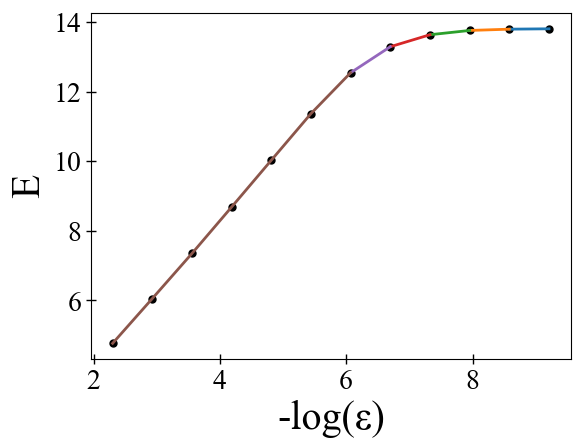

In [87]:
using PyPlot, ChaosTools # ChaosTools belongs to DynamicalSystems
# ChaosTools brings a function `plot_linear_regions`
figure(figsize=(6,4))
plot_linear_regions(x, Es)
xlabel("-log(ε)"); ylabel("E");

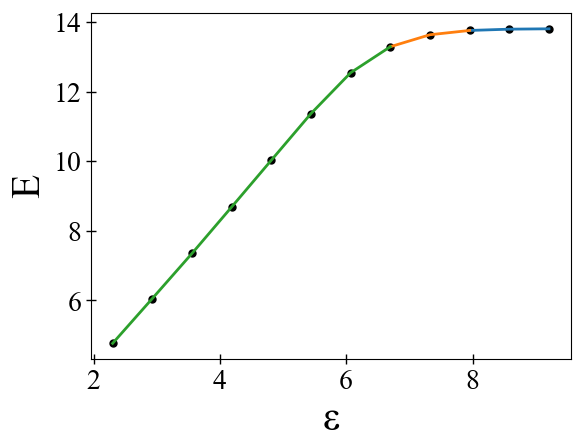

In [72]:
figure(figsize=(6,4))

# Adjust the tolerance of linear_regions using keyword argument `tol`

plot_linear_regions(x, Es; tol = 0.8)
xlabel("ε"); ylabel("E");

## `generalized_dim` function

Let's summarize what we just did to estimate the dimension of an attractor.

1. We decided on some partition sizes `ες` to use.
    * The function `estimate_boxsizes` can give an estimate for that.
2. For each `ε in ες` we calculated the `genentropy`, and got an array `Es`.
3. We tried to find a "linear scaling region" of the curve `Es` vs. `-log.(ες)`.
4. The slope of this "linear scaling region" is the dimension we estimated.

Wouldn't it be **amazing** if all of this process could happen with one function call?

In [73]:
generalized_dim(2.0, tr)

2.0254102342594864

In [74]:
information_dim(tr) # ≡ generalized_dim(1, tr)

2.0857728648410996

In [75]:
# Let's do the same for the Henon map that we have seen in previous tutorials
hen = Systems.henon()
tr = trajectory(hen, 100000)
capacity_dim(tr) # ≡ generalized_dim(0, tr)

1.1856522479973168

In [76]:
# Same for the lorenz system
lor = Systems.lorenz()
tr_lor = trajectory(lor, 1000.0; dt = 0.05);

In [77]:
capacity_dim(tr_lor)

1.720547762486172

The above is a *wrong* result. It is known that the capacity dimension of the Lorenz attractor (for default parameters) is around 2.0 (Grassberger and Procaccia, 1983)!

**It is important to understand that `generalized_dim` is only a crude estimate. NOT to be trusted for accurate results!**

In [78]:
es = estimate_boxsizes(tr_lor)
ds = genentropy.(0, es, tr_lor)
hcat(es, ds) # show es next to ds

12×2 Array{Float64,2}:
  0.1       9.85183
  0.151991  9.78847
  0.231013  9.6453 
  0.351119  9.35531
  0.53367   8.89261
  0.811131  8.27665
  1.23285   7.59589
  1.87382   6.87626
  2.84804   6.12687
  4.32876   5.3845 
  6.57933   4.62497
 10.0       3.91202

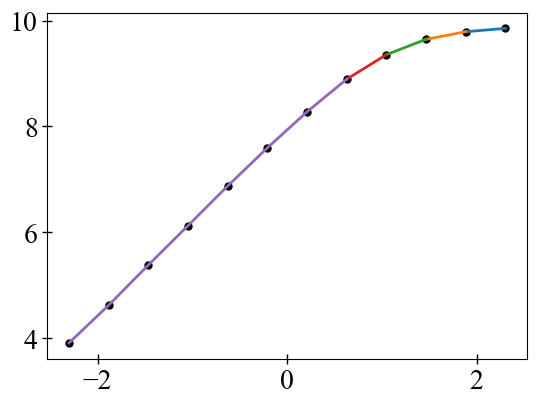

In [79]:
# visualize what linear regions finds...
figure(figsize = (6,4))
plot_linear_regions(-log.(es), ds)

* The `linear_regions` estimator seems to work fine.

points used: 20001

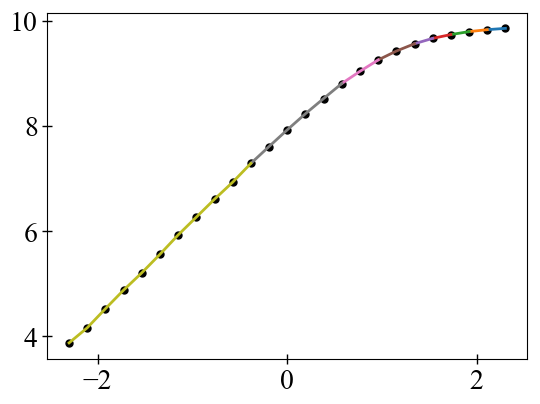


D = 1.794942988068242


In [80]:
tr_lor = trajectory(lor, 10000.0, rand(3); dt = 0.5) #, diff_eq_kwargs = Dict(:maxiters => typemax(Int)));

# Let's try estimations with different boxsizes:
sizes = logspace(-1, 1, 25)
# form 10^(a) to 10^(b)

ds = genentropy.(0, sizes, tr_lor)

figure(figsize=(6,4))
plot_linear_regions(-log.(sizes), ds)
D = linear_region(-log.(sizes), ds)[2]
println("points used: $(length(tr_lor))")
println("D = $(D)")

# Other related concepts
## Kaplan-Yorke dimension
The Kaplan-Yorke dimension is defined as simply the (interpolated) number where the sum of Lyapunov exponents crosses zero.

This simple interpolation is done by the function `kaplanyorke_dim(ls)`.

In [81]:
lor = Systems.lorenz()

ls = lyapunovs(lor, 4000.0; Ttr = 100.0)

3-element Array{Float64,1}:
   0.906237 
   4.4089e-5
 -14.5729   

In [82]:
kaplanyorke_dim(ls)

2.0621892866293345

This result is much closer to the one known in the literature.

## Permutation Entropy

Another entropy-like quantity that you can compute with **DynamicalSystems.jl** is the [permutation entropy](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/entropies/#permutation-entropy).

This is done with the function `permentropy(s, order; ...)`. The permutation entropy is different because it requires a *timeseries* `s` as the input, i.e. a signal. 

In [94]:
# create timeseries:
s = (ds = Systems.towel(); trajectory(towel, 10000)[:, 1])
# order `o` permutation entropy:
o = 6
permentropy(s, o)

3.600068724233908

# Docstrings

In [83]:
?genentropy

search: genentropy



```
genentropy(α, ε, dataset::AbstractDataset; base = e)
```

Compute the `α` order generalized (Rényi) entropy [1] of a dataset, by first partitioning it into boxes of length `ε` using [`non0hist`](@ref).

```julia
genentropy(α, p::AbstractArray; base = e)
```

Compute the entropy of an array `p` directly, assuming that `p` is sum-normalized.

Optionally use `base` for the logarithms.

## Description

Let $p$ be an array of probabilities (summing to 1). Then the Rényi entropy is

$$
R_\alpha(p) = \frac{1}{1-\alpha} \log \left(\sum_i p[i]^\alpha\right)
$$

and generalizes other known entropies, like e.g. the information entropy ($\alpha = 1$, see [2]), the maximum entropy ($\alpha=0$, also known as Hartley entropy), or the correlation entropy ($\alpha = 2$, also known as collision entropy).

## References

[1] : A. Rényi, *Proceedings of the fourth Berkeley Symposium on Mathematics, Statistics and Probability*, pp 547 (1960)

[2] : C. E. Shannon, Bell Systems Technical Journal **27**, pp 379 (1948)


In [84]:
?generalized_dim

search: generalized_dim



```
generalized_dim(α, dataset [, sizes]) -> D_α
```

Return the `α` order generalized dimension of the `dataset`, by calculating the [`genentropy`](@ref) for each `ε ∈ sizes`.

## Description

The returned dimension is approximated by the (inverse) power law exponent of the scaling of the [`genentropy`](@ref) versus the box size `ε`, where `ε ∈ sizes`.

Calling this function performs a lot of automated steps:

1. A vector of box sizes is decided by calling `sizes = estimate_boxsizes(dataset)`, if `sizes` is not given.
2. For each element of `sizes` the appropriate entropy is calculated, through `d = genentropy.(α, sizes, dataset)`. Let `x = -log.(sizes)`.
3. The curve `d(x)` is decomposed into linear regions, using [`linear_regions`](@ref)`(x, d)`.
4. The biggest linear region is chosen, and a fit for the slope of that region is performed using the function [`linear_region`](@ref). This slope is the return value of `generalized_dim`.

By doing these steps one by one yourself, you can adjust the keyword arguments given to each of these function calls, refining the accuracy of the result.

The following aliases are provided:

  * α = 0 : `boxcounting_dim`, `capacity_dim`
  * α = 1 : `information_dim`


In [85]:
?non0hist

search: non0hist



```julia
non0hist(ε, dataset::AbstractDataset)
```

Partition a dataset into tabulated intervals (boxes) of size `ε` and return the sum-normalized histogram in an unordered 1D form, discarding all zero elements.

## Performances Notes

This method is effecient in both memory and speed, because it uses a dictionary to collect the information of bins with elements, while it completely disregards empty bins. This allows computation of entropies of high-dimensional datasets and with small box sizes `ε` without memory overflow.

Use e.g. `fit(Histogram, ...)` from [`StatsBase`](http://juliastats.github.io/StatsBase.jl/stable/) if you wish to keep information about the edges of the binning as well as the zero elements.


In [86]:
?linear_regions

search: linear_regions plot_linear_regions linear_region



```
linear_regions(x, y; dxi::Int = 1, tol = 0.2) -> (lrs, tangents)
```

Identify regions where the curve `y(x)` is linear, by scanning the `x`-axis every `dxi` indices (e.g. at `x[1] to x[5], x[5] to x[10], x[10] to x[15]` and so on if `dxi=5`).

If the slope (calculated using `LsqFit`) of a region of width `dxi` is approximatelly equal to that of the previous region, within tolerance `tol`, then these two regions belong to the same linear region.

Return the indices of `x` that correspond to linear regions, `lrs`, and the approximated `tangents` at each region. `lrs` is a vector of `Int`.

A function `plot_linear_regions` visualizes the result of using this `linear_regions` (requires `PyPlot`).


In [95]:
?permentropy

search: permentropy



```
permentropy(x::AbstractVector, order [, interval=1]; base = e)
```

Compute the permutation entropy [1] of given `order` from the `x` timeseries.

Optionally, `interval` can be specified to use `x[t0:interval:t1]` when calculating permutation of the sliding windows between `t0` and `t1 = t0 + interval * (order - 1)`.

Optionally use `base` for the logarithms.

## References

[1] : C. Bandt, & B. Pompe, [Phys. Rev. Lett. **88** (17), pp 174102 (2002)](http://doi.org/10.1103/PhysRevLett.88.174102)
